# Vehicle Detection
To detect vehicles in images we will perform the following steps:
    1. HOG detection
    2. Color feature extraction
    3. Data preparation
    4. Classifier training
    5. Sliding window implementation
    6. Search and Classify
    7. Multiple Detection and reduce false positives
    8. Creating a pipeline to detect objects in a movie 

## HOG Detection
To perform Histogram Orientation Detection (HOG) we have multiple parameters to pick. First we have to choose the colorspace. We found in literature that YCrCb is a popular color space. This is described in [Creusen et al., 2010](https://pure.tue.nl/ws/files/3283178/Metis245392.pdf) where the authors describe that the best traffic sign detection are found by means of the CIELab and YCrCb color space. In [Baghel et al., 2017](http://www.ijcaonline.org/archives/volume134/number7/23927-2016907926) the authors have success removing shadow using YCrCb color space. As such we are interested in creating a HOG feature map for the Cb and the Cr channgels. Since the Y channel in YCrCb encodes a grayscale image we will use that image for our HOG detection.

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

In [21]:
%matplotlib inline

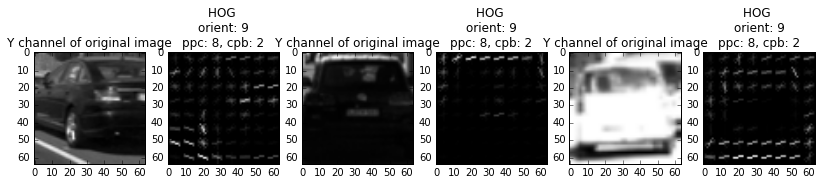

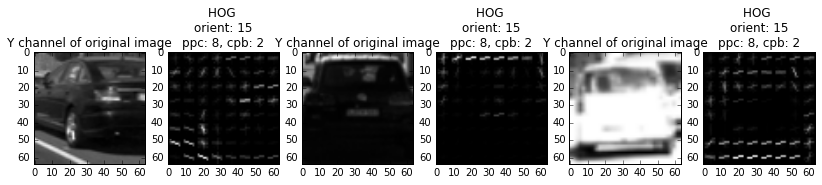

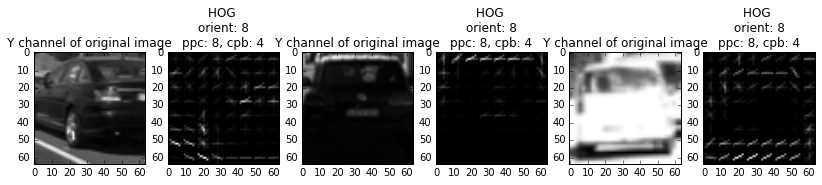

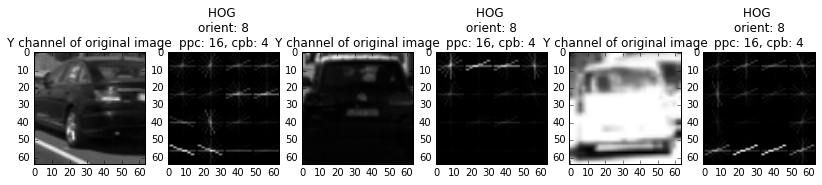

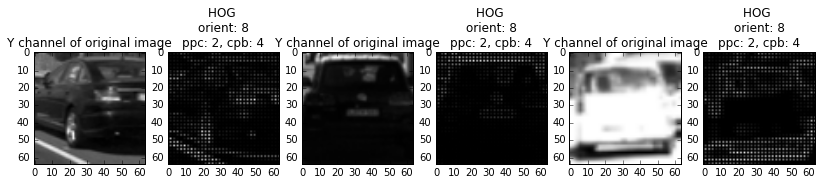

In [128]:
   
def plot_hog_sample(images, orient, pix_per_cell, cell_per_block):
    num_img = len(images) * 20
    img_idx = 1
    fig = plt.figure(figsize=(14,6))
    for image_name in images:
        # Read the image and convert it to YCrCb color space
        img = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2YCR_CB)
        img_Y = img[:,:,0]
        img_Y = img_Y.astype(np.float64)
        feature, hog_image = hog(img_Y, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        plt.subplot(100 + num_img + img_idx)
        img_idx += 1
        plt.title('Y channel of original image')
        plt.imshow(img_Y, cmap='gray')
        plt.subplot(100 + num_img + img_idx)
        img_idx += 1
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG \norient: %s\nppc: %s, cpb: %s' %
                 (orient, pix_per_cell, cell_per_block))

test_images = ['./vehicles/GTI_Right/image0003.png', './vehicles/KITTI_extracted/108.png',
               './vehicles/KITTI_extracted/249.png']
plot_hog_sample(test_images, 9, 8, 2)
# Let us increase the orientation bins. The drawback of having more orientation bins is that the 
# classifier will need to learn more features.
plot_hog_sample(test_images, 15, 8, 2)
# Let us decrease the orientation bins to 8 and increase the cell per block
plot_hog_sample(test_images, 8, 8, 4)
# Let us also increase the pixels per cell
plot_hog_sample(test_images, 8, 16, 4)
# Let us decrease the pixels per cell
plot_hog_sample(test_images, 8, 2, 4)

We see from altering the parameters that our initial parameters were actually quite good. As described in [Ballesteros et al., 2014](http://www.eurasip.org/Proceedings/Eusipco/Eusipco2014/HTML/papers/1569924423.pdf) the optimal number of cell blocks for SVM classifier depends on whether an object is at the right, center or left and near or far. We see that 8 orientation bins is optimal with 4 cells per block size 2. We see from the last row of images that this leads to a large grid which may complicate the computation at a later stage. For now we will however continue with these value.

## Color Feature Extraction
We used HOG on the Y channel of the YCrCb encoding. We will encode the Cr and Cb channels with a histogram and perform normalization.

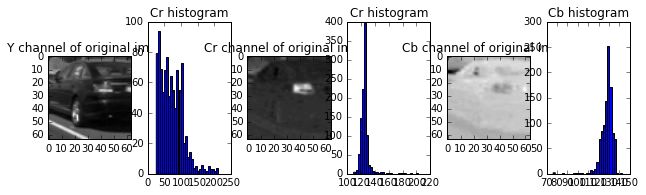

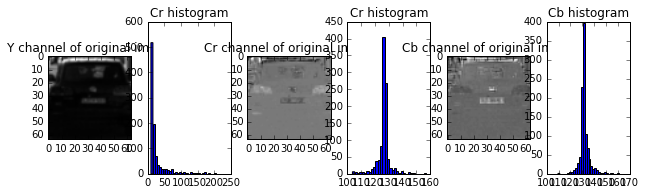

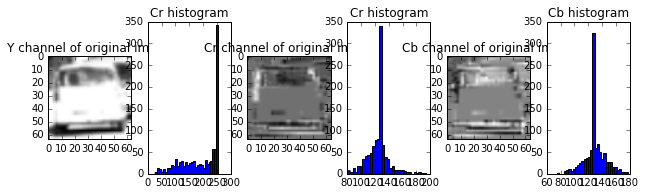

In [58]:
def histograms(img, size = 32):
    features = cv2.resize(img, (size, size)).ravel()
    return features
   
def plot_hist_sample(images):
    num_img = len(images) * 60
    for image_name in images:
        # Read the image and convert it to YCrCb color space
        fig = plt.figure(figsize=(14,6))
        img = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2YCR_CB)
        img_Y = img[:,:,0].astype(np.float64)
        feature = histograms(img_Y)
        img_idx = 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Y channel of original image')
        plt.imshow(img_Y, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 32)
        plt.title('Cr histogram')
        img_Cr = img[:,:,1].astype(np.float64)
        feature = histograms(img_Cr)
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Cr channel of original image')
        plt.imshow(img_Cr, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 32)
        plt.title('Cr histogram')
        img_Cb = img[:,:,2].astype(np.float64)
        feature = histograms(img_Cb)
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Cb channel of original image')
        plt.imshow(img_Cb, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 32)
        plt.title('Cb histogram')
        
plot_hist_sample(test_images)

We see that we get interesting peaks in the histograms and that even standardized they cannot be substituted. This is particularly clear in the first figure. The histogram of the Cr channel is skewed to the left whereas the Cb channel is skewed to the left. We will therefore use all three.

## Combining Features
Next we combine the features that we extracted above. We first compute all the features and scale the entire concatenated feature vector at once. We will see however that this leads to outliers showing up and all HOG features to dissappear. In our second attempt we standardize the YCrCb features and the HOG features separately. This leads to more variation.

In [139]:
from sklearn.preprocessing import StandardScaler

def color_hist(img, nbins=32, bins_range=(0,256)):
    Y_channel = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    Cr_channel = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    Cb_channel = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_feature = np.concatenate((Y_channel[0], Cr_channel[0], Cb_channel[0]))
    return hist_feature

def hog_features(img, orient=8, pix_per_cell=2, cell_per_block=4):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=False)
    return features
 

def extract_features_norm_all(img, size=32):
    img = cv2.resize(img, (size, size))
    hog_feat = hog_features(img[:,:,0])
    color_feat = color_hist(img)
    all_features = np.concatenate((hog_feat, color_feat))
    all_features = all_features.reshape(-1, 1).astype(np.float64)
    scaler = StandardScaler().fit(all_features)
    scaled_features = scaler.transform(all_features)
    return scaled_features



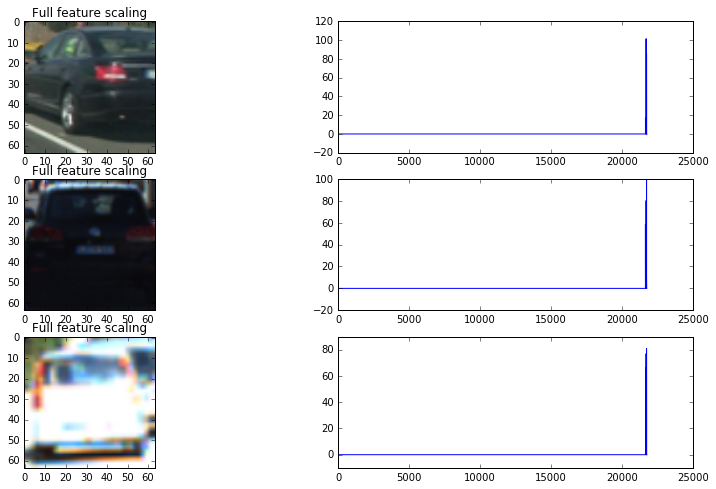

In [140]:
import matplotlib.gridspec as gridspec

def plot_features_norm_all(images):
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(len(images),2)
    for i, image_name in enumerate(images):
        # Read the image and convert it to YCrCb color space
        img = cv2.imread(image_name)
        img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        ax = plt.subplot(gs[i * 2])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        features = extract_features_norm_all(img_conv)
        plt.title('Full feature scaling')
        ax = plt.subplot(gs[i * 2 + 1])
        ax.plot(features)
   
    return None
       
plot_features_norm_all(test_images)

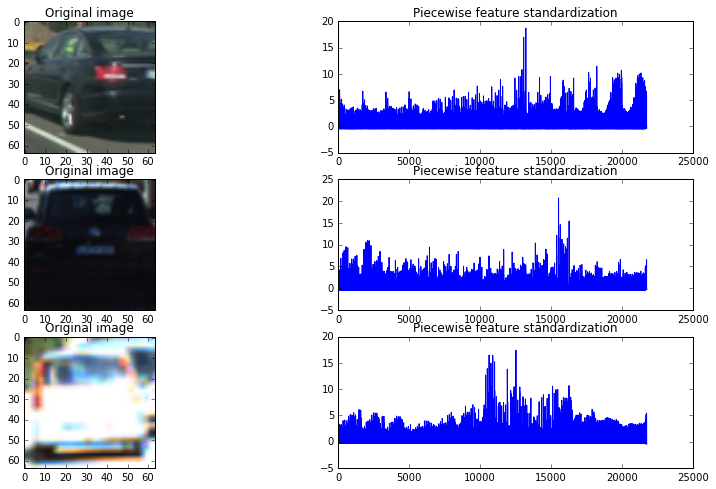

In [141]:
def extract_features_norm_pc(img, size=32):
    img = cv2.resize(img, (size, size))
    hog_feat = hog_features(img[:,:,0]).reshape(-1,1).astype(np.float64)
    hog_feat_sclr = StandardScaler().fit(hog_feat)
    hog_feat_sc = hog_feat_sclr.transform(hog_feat)
    color_feat = color_hist(img).reshape(-1,1).astype(np.float64)
    color_feat_sclr = StandardScaler().fit(color_feat) 
    color_feat_sc = color_feat_sclr.transform(color_feat)
    all_features = np.concatenate((hog_feat_sc, color_feat_sc))
    return all_features

def plot_features_norm_pc(images):
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(len(images),2)
    for i, image_name in enumerate(images):
        # Read the image and convert it to YCrCb color space
        img = cv2.imread(image_name)
        img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        img_idx = 1
        ax = plt.subplot(gs[i * 2])
        plt.title('Original image')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        features = extract_features_norm_pc(img_conv)
        ax = plt.subplot(gs[i * 2 + 1])
        plt.title('Piecewise feature standardization')
        ax.plot(features)
        
    return None
       
plot_features_norm_pc(test_images)

We see that piecewise scaling yields the HOG features, which are more on the left part of the graph, as well as the YCrCb features, which are more on the right, to show up in equal amounts.

In [ ]:
import glob
import pickle

car_features = []
noncar_features = []

for img_fn in glob.iglob('vehicles/**/*png')[:10]:
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2YCR_CB)
    car_features.append(extract_features_norm_pc(img))

for img_fn in glob.iglob('non-vehicles/**/*png')[:10]:
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2YCR_CB)
    noncar_features.append(extract_features_norm_pc(img))

pickle.dump([car_features, noncar_features], open('features.p', 'wb'))